# process spectra for AuxTel with new spectractor (September 2021): Part 1 guess (x,y) of order 0

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : June 16th 2021
- up date : September 21th  2021
- update : September 24th 2021 : quickLookExp and run locally
- update : September 29th 2021 : for diffusion
- version v3


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [49]:
from iminuit import Minuit
import iminuit

In [50]:
iminuit.__version__

'2.7.0'

In [51]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [52]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [53]:
from distutils.dir_util import copy_tree

# Configuration

In [54]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [55]:
# path index for each month
DATE="2021-07-07"
DATE2="2021_07_07"

In [56]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [57]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/holo/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)

# Utility Functions

In [58]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [59]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [60]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [61]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_v4.0.csv'

In [62]:
df=pd.read_csv(filename_logbook,index_col=0)

In [63]:
pd.set_option('display.max_rows', None)

In [64]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,1900.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [65]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [66]:
#idx=76
#idx=96
idx=76

In [67]:
print(df.iloc[idx]['file'])

holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits


In [68]:
print(df.iloc[idx])

index                                                         76
date                                     2021-07-08T04:49:32.013
path           /Users/dagoret/DATA/AuxTelData2021/holo/quickL...
file           holo4_003_empty_HD160617_20210707_000317_quick...
num                                                          317
object                                                  HD160617
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.065945
exposure                                                    20.0
focus                                                  -1.577194
seeing                                                       NaN
pressure                                                  742.25
temperature                                                 12.3
humidity                                                     6.0
windspd                  

In [69]:
myhome=os.getenv("HOME")

In [70]:
dir_images=path_images

In [71]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [72]:
file_target(filename_image)

'HD160617'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [73]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [74]:
FLAG_ORDER0_LOCATION=False

In [75]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (500.0,1900.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [76]:
filename_image.split(".")[0]

'holo4_003_empty_HD160617_20210707_000317_quickLookExp'

In [77]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07'

In [78]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_holo_scan"
output_figures="figures_process_holo_scan"

# Final output directory


guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

target = file_target(filename_image)[0]

In [79]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp'

### manage output dir

In [80]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                os.remove(os.path.join(path,f))

In [81]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [82]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [83]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- the image fits format extracted from quickLookExp images at NCSA has not the exact format required by Spectractor.

In [84]:
from shutil import copyfile

In [85]:
copyfile(filename,filename_image)

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [86]:
from astropy.io import fits

In [87]:
hdu = fits.open(filename_image)

In [88]:
hdu.info()

Filename: holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [89]:
# extract header and the image
header=hdu[0].header
image=hdu[0].data

In [90]:
hdu.close()

## Rotate image

- rotate the image according what is expected in Spectractor

In [91]:
if version=="v3.0":
    rot_image=np.flip(np.flip(image, 1), 0)
else:
    rot_image=np.flip(image, 0)

### Remove WCS

- may not be necessary

In [92]:
if FLAG_REMOVE_WCS:
    del header['WCSAXES']
    del header['CTYPE1']
    del header['CTYPE2']
    del header['CUNIT1']
    del header['CUNIT2']
    del header['CRVAL1']
    del header['CRVAL2']
    del header['CRPIX1']
    del header['CRPIX2']

### Put the Hour angle in hour units

In [93]:
header["HASTART"]=header["HAEND"]  # Spectractor search for HASTART in Hour

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [94]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [95]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [96]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [97]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new image file with Spectractor

In [98]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [99]:
parameters.OBS_NAME

'AUXTEL'

In [100]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [101]:
parameters.DISTANCE2CCD

182.0

In [102]:
parameters.LAMBDA_MIN 

300

In [103]:
parameters.LAMBDA_MAX 

1100

In [104]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [105]:
image.filter_label

''

In [106]:
image.header["FILTER"]

'empty_1'

In [107]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

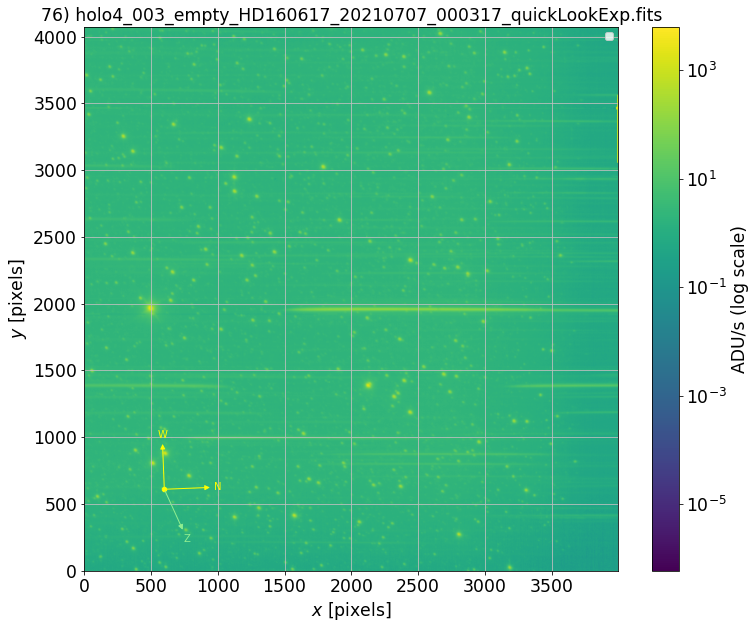

In [108]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

In [109]:
# with filter
guess = [600., 2100.] # filename_image=df['file'][0] , holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][1] , holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][2] , holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][3] , holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][4] , holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][5] , holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][6] , holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][7] , holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][8] , holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][9] , holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
guess = [1300., 700.] # filename_image=df['file'][10] , holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][11] , holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][12] , holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][13] , holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits


# wide scan
guess = [1400., 700.] # filename_image=df['file'][14] , holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
guess = [1400., 800.] # filename_image=df['file'][15] , holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][16] , holo4_003_empty_HD160617_20210707_000250_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][17] , holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][18] , holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][19] , holo4_003_empty_HD160617_20210707_000253_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][20] , holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][21] , holo4_003_empty_HD160617_20210707_000255_quickLookExp.fits

#

# narrrow scan

guess = [500.,2100.] # filename_image=df['file'][76] , 'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'
guess = [500.,2100.] # filename_image=df['file'][77] , 'holo4_003_empty_HD160617_20210707_000318_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][78] , 'holo4_003_empty_HD160617_20210707_000319_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][79] , 'holo4_003_empty_HD160617_20210707_000320_quickLookExp.fits'
guess = [500.,1300.] # filename_image=df['file'][80] , 'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [110]:
filename_image

'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'

In [111]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (500.0,1900.0)


## Let Spectractor find the location of the 0th order

2021-10-08 15:26:32  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                  c0_1        
    ----------------- ----------------------- --------------------
    2.248163293819285 -0.00024012120497443346 0.016983620730871618
2021-10-08 15:26:32  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 16 iterations because the relative change of cost is below ftol=1.25e-05.


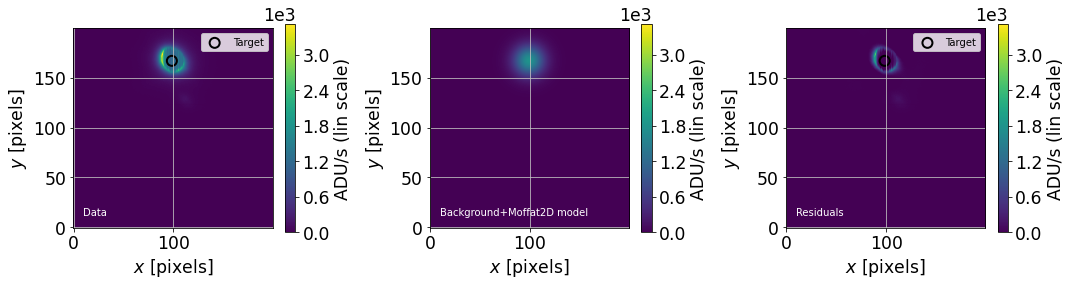

2021-10-08 15:26:33  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 6 iterations because the relative change of cost is below ftol=6.0240963855421684e-05.


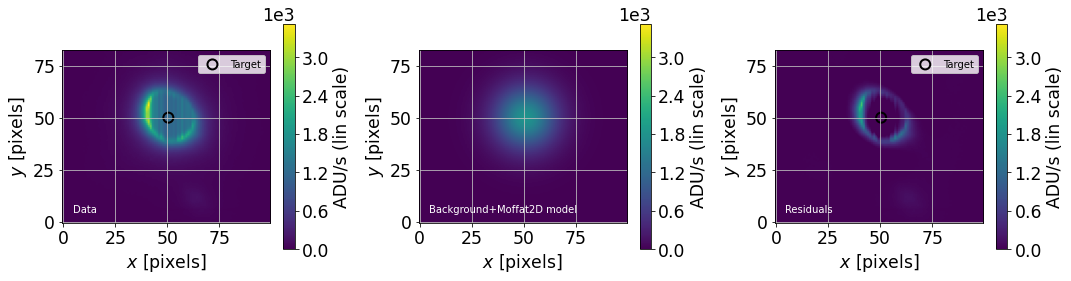

In [112]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [113]:
print(x1,y1)

498.50282698036733 1967.0212203960036


## Check the location of 0th order and Analysis of the quality of its focus

In [114]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [115]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [116]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [117]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [118]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [119]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [120]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [121]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [122]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [123]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [124]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [125]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [126]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-127-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '76) holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits')

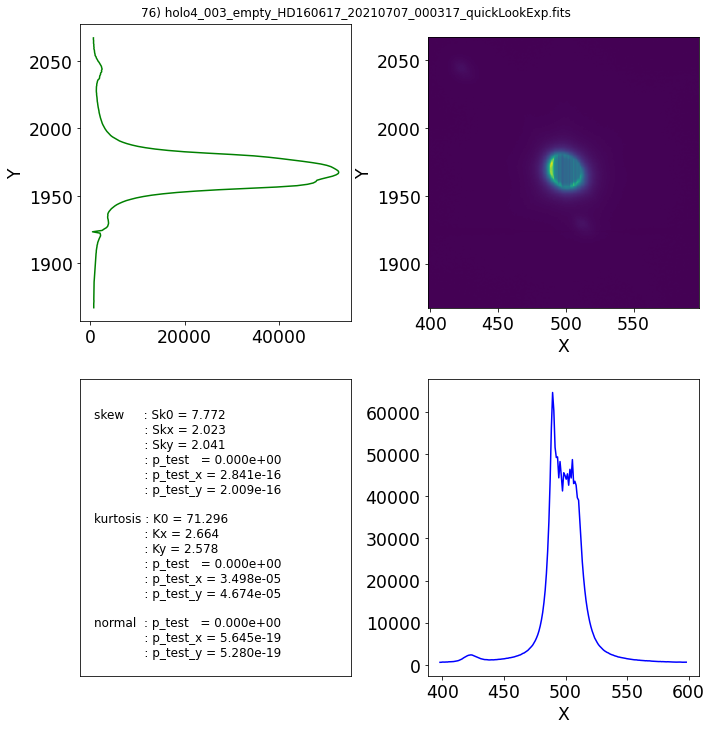

In [127]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [128]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [129]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

2021-10-08 15:26:35  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-10-08 15:26:35  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits...
2021-10-08 15:26:35  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: False	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: False	 <class 'bool'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> par

2021-10-08 15:26:35  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-10-08 15:26:35  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-10-08 15:26:35  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-10-08 15:26:40  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD 160617 17 42 49.3235 -40 19 15.505 ... 0.0003350                1
2021-10-08 15:26:40  Star       load_spectra         INFO   
	Loading /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd160617_stis_001.fits
2021-10-08 15:26:40  Star       load_

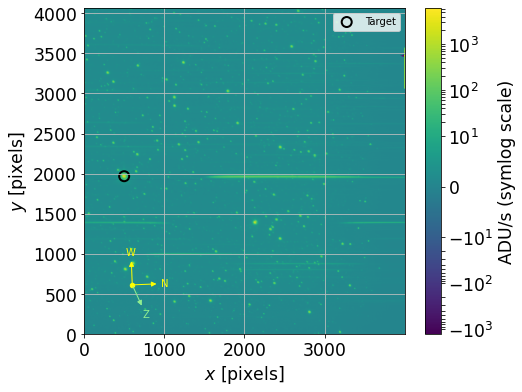

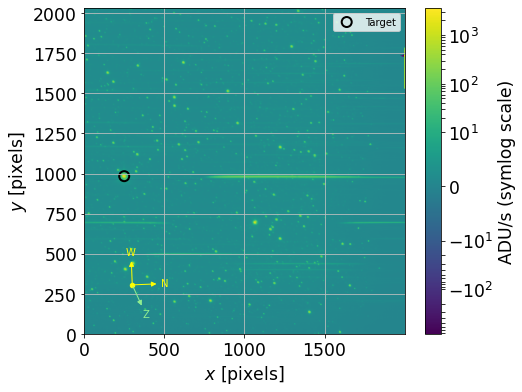

2021-10-08 15:26:46  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[249.25141349 983.5106102 ]...
2021-10-08 15:26:46  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1        
    ----------------- --------------------- --------------------
    4.685079956054531 -0.003892960456662491 0.004043754130649126
2021-10-08 15:26:47  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 12 iterations because the relative change of cost is below ftol=5e-05.


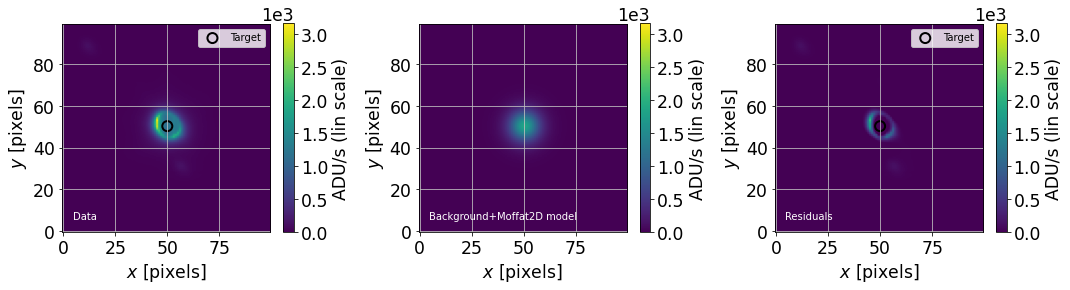

2021-10-08 15:26:48  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


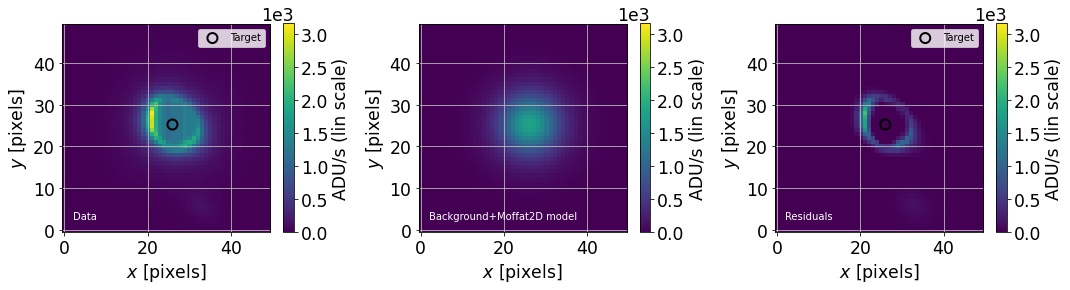

2021-10-08 15:26:49  Image      find_target          INFO   
	X,Y target position in pixels: 248.991,983.272
2021-10-08 15:26:49  Image      turn_image           INFO   
	Rotate the image with angle theta=0.00 degree


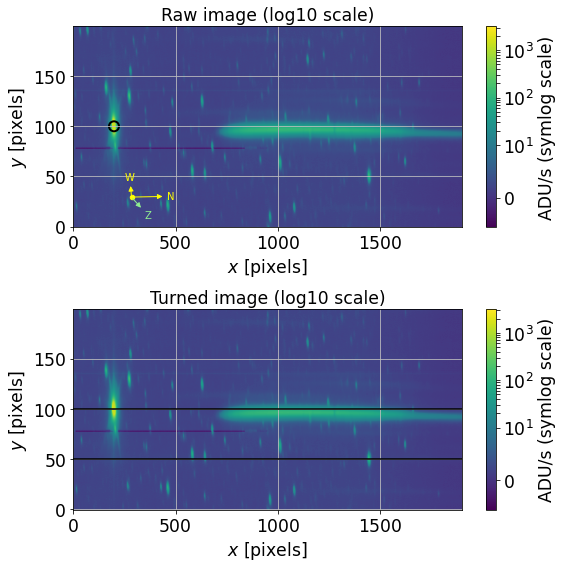

2021-10-08 15:26:53  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-10-08 15:26:53  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1        
    ------------------ ------------------- --------------------
    15.961386682927476 0.17678001231303012 0.017156022003925152
2021-10-08 15:26:53  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 9 iterations because the relative change of cost is below ftol=0.0002.


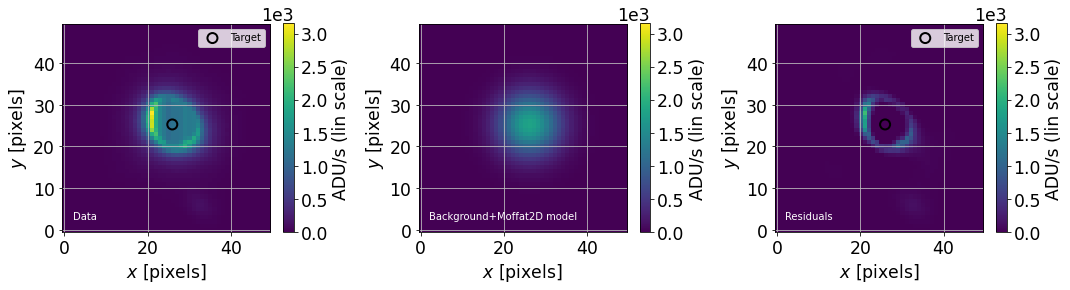

2021-10-08 15:26:54  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 1 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-06.


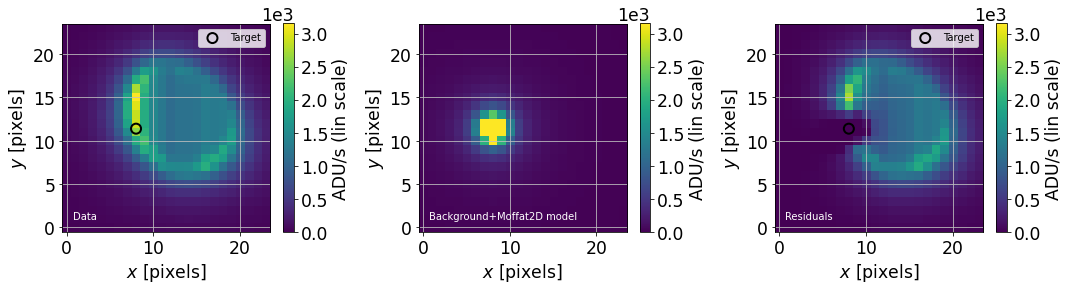

2021-10-08 15:26:55  Image      find_target          INFO   
	X,Y target position in pixels: 244.015,982.392
2021-10-08 15:26:55  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-10-08 15:26:55  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-10-08 15:26:55  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [670:1828,892:1072] (size (1158, 180))


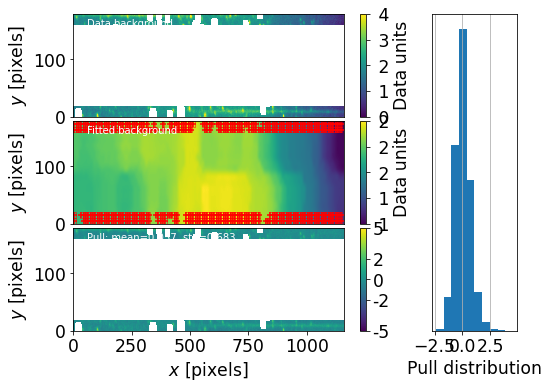

2021-10-08 15:26:58  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...


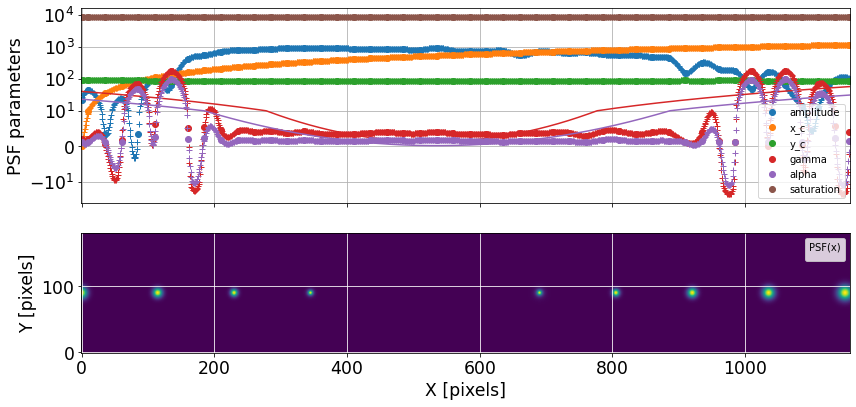

2021-10-08 15:27:03  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.7613e+05 initial chisq_red=3.8024
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.18219583 -0.22453044 -0.47451632 -1.47688685 -1.53311961 -3.68674147
 -1.05271927 -1.09141645 -2.55182814]
	New parameters: [-3.93701409 -0.99455624 -2.19746018  4.45166047 -0.17993854  1.95071185
  1.64436244 -0.23162974  0.28104919]
	Final cost=1.4141e+05 final chisq_red=3.0528 computed in 0.88s
2021-10-08 15:27:03  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.4141e+05 initial chisq_red=3.0528
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.0009101  -0.0013219   0.00485438 -0.09460197 -0.01216966 -0.49037664
  0.08916685  0.13038823  0.01748808]
	New parameters: [-3.93610399 -0.99587814 -2.1926058   4.35705851 -0.19210819  1.46033521
  1.73352929 -0.10124151  0.29853728]
	Final cost=1.2326e+05 final chisq_red=2.6611 computed i

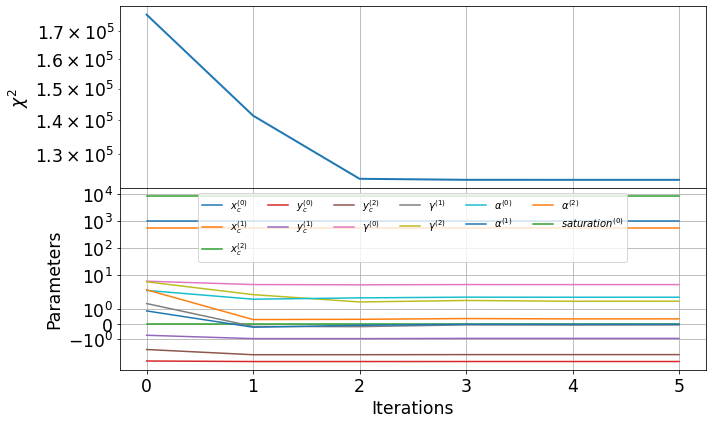

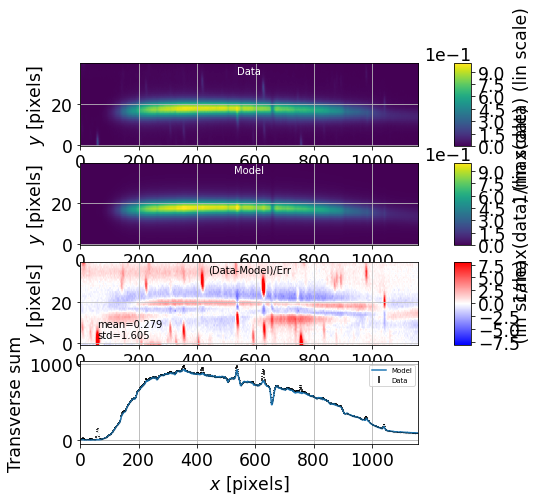

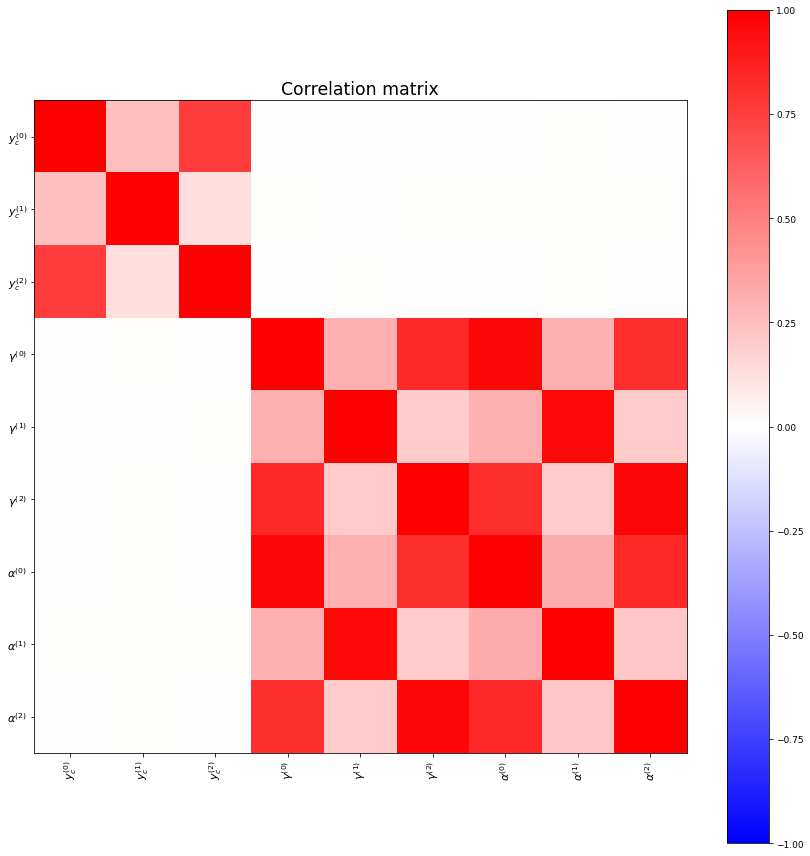

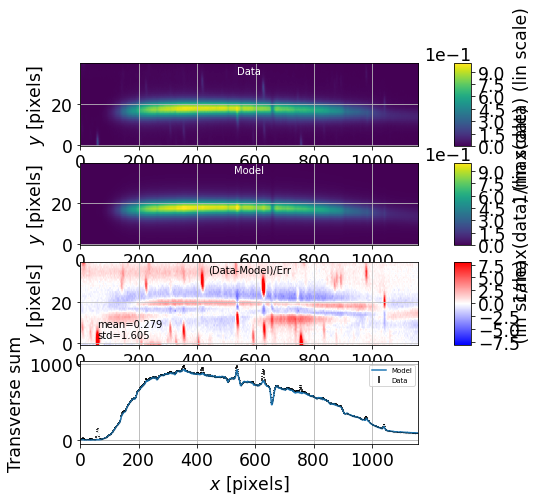

2021-10-08 15:27:12  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
    amplitude       x_c          y_c        ...          Dy         Dy_disp_axis
------------------ ------ ----------------- ... ------------------- ------------
 7.406815835872398    0.0  85.2712312973853 ...  -5.120589298897556          0.0
6.5393577355757975    1.0 85.28080154545042 ...  -5.111019050832439          0.0
 6.938568445175195    2.0 85.29035230071133 ...  -5.101468295571522          0.0
  3.57390868743792    3.0 85.29988356316805 ...  -5.091937033114803          0.0
 6.507900809085118    4.0 85.30939533282057 ...  -5.082425263462284          0.0
 5.210105898474079    5.0 85.31888760966889 ...  -5.072932986613964          0.0
 5.334052805414092    6.0 85.32836039371301 ...  -5.063460202569843          0.0
 7.390917447871159    7.0 85.33781368495293 ...  -5.054006911329921          0.0
 6.527988490283191    8.0 85.34724748338866 ...  -5.04457311

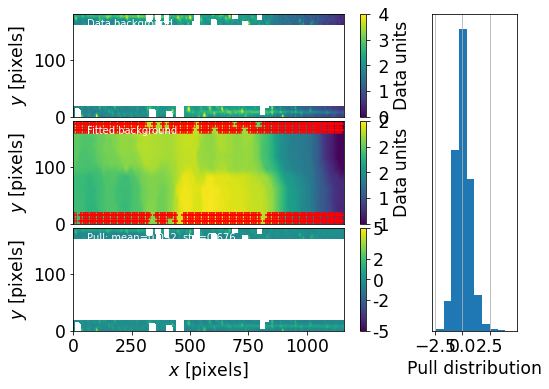

2021-10-08 15:27:15  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.000 ADU/s, RMS=0.282 ADU/s.
2021-10-08 15:27:15  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [673:1831,893:1074] (size (1158, 181))
	New target position in spectrogram frame: [-424.0090601787689, 90.27184590925094]


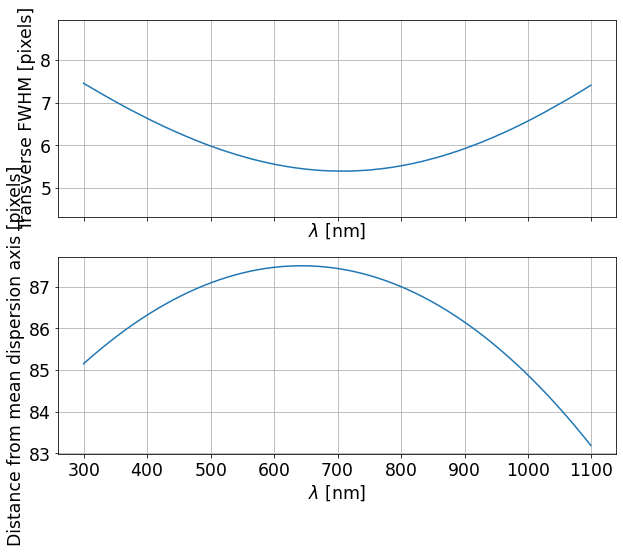

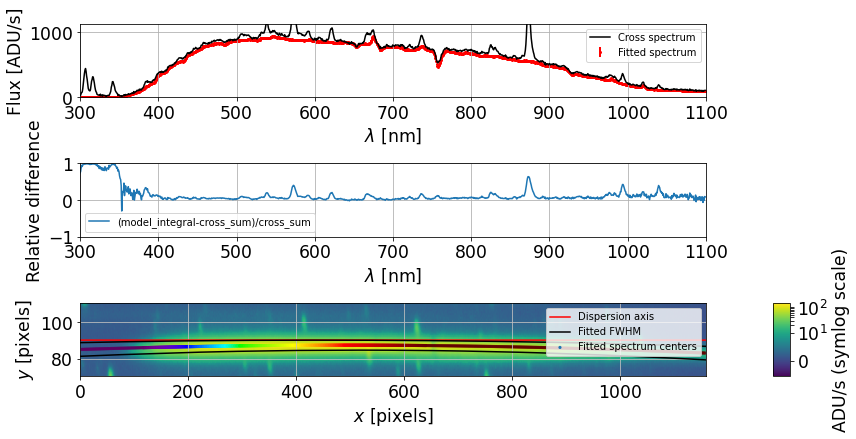

2021-10-08 15:27:17  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


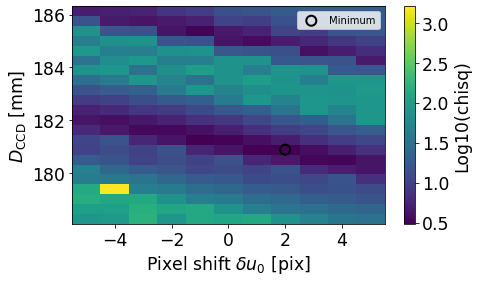

2021-10-08 15:27:38  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: 1.509pix
	D = 180.890 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -1.5 sigma shift)
2021-10-08 15:27:40  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-10-08 15:27:56  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=6.1075e+06 initial chisq_red=146.2
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-1.08657036 -0.11445861]
	New parameters: [-1.08657036 -0.11445861]
	Final cost=1.3636e+06 final chisq_red=32.642 computed in 14.20s
2021-10-08 15:28:10  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.3636e+06 initial chisq_red=32.642
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.84774794 -0.01530251]
	New parameters: [-1.904      -0.12976112]
	Final cost=8.9241e+05 final chisq_red=21.362 computed in 14.12s
2021-10-08 15:28:24

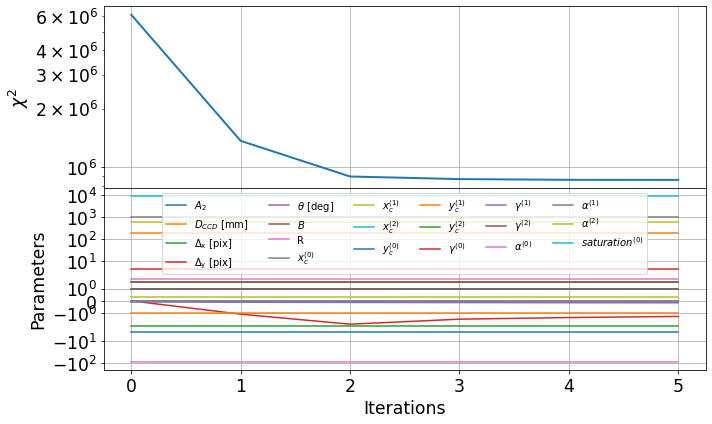

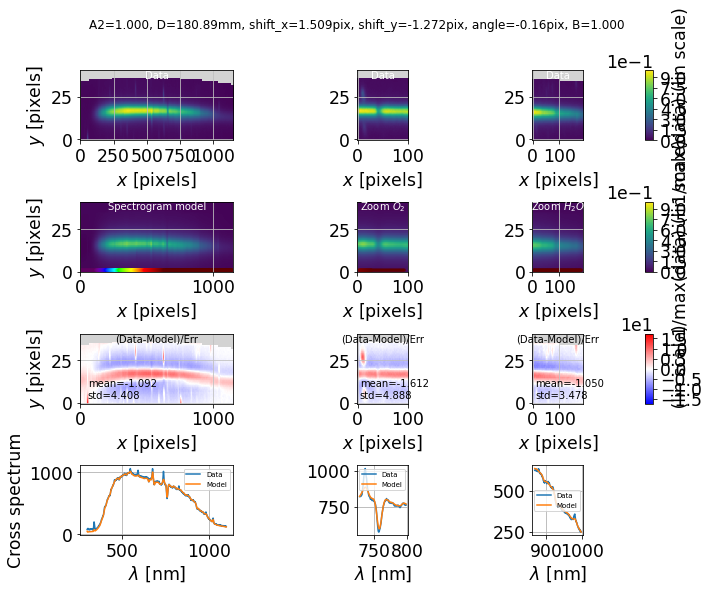

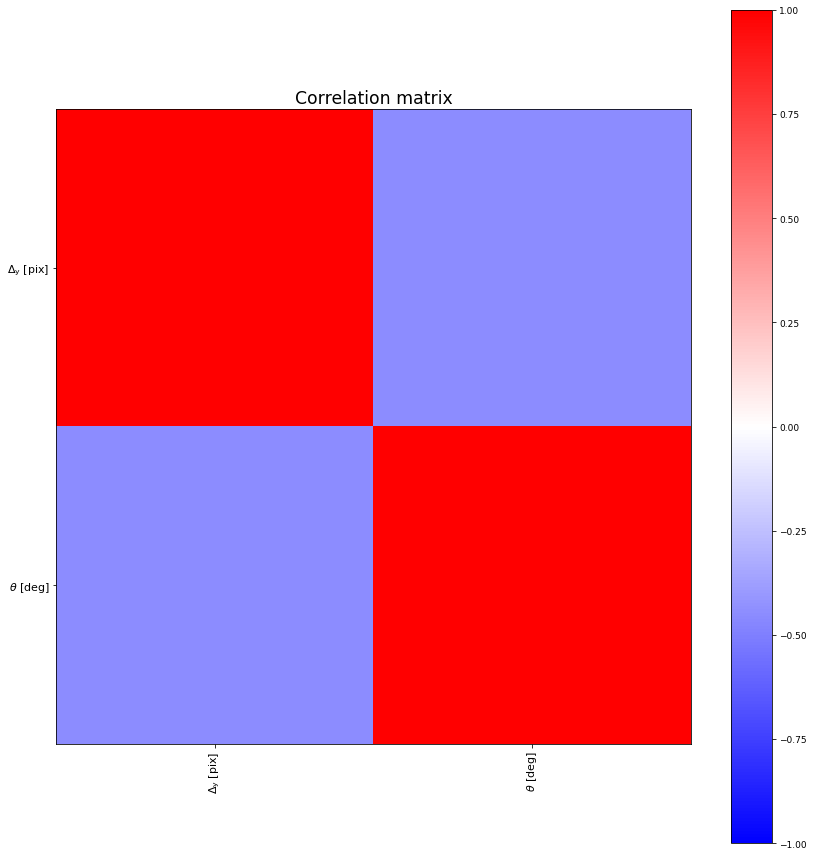

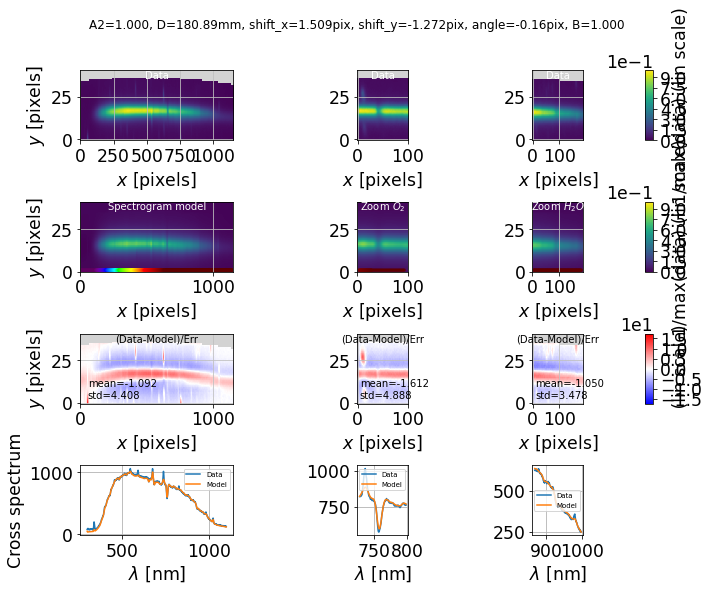

2021-10-08 15:29:09  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.80890437e+02  1.50858813e+00 -1.27191305e+00
 -1.59820408e-01  1.00000000e+00 -8.77528175e+01  1.00448493e+03
  5.78500000e+02 -4.73349470e-13 -3.92756631e+00 -9.81478912e-01
 -2.17450190e+00  4.43664246e+00 -7.74785993e-02  1.51151634e+00
  1.77695792e+00 -3.52763543e-02  3.28407140e-01  8.50000000e+03]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-10-08 15:29:35  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=8.5721e+05 initial chisq_red=20.52
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.21557853 -0.00669868 -1.09035797 -0.19648773  0.00395147  0.11940217
 -0.01426845  0.03832737]
	New parameters: [-1.05633452 -0.16651909  3.34628449 -0.

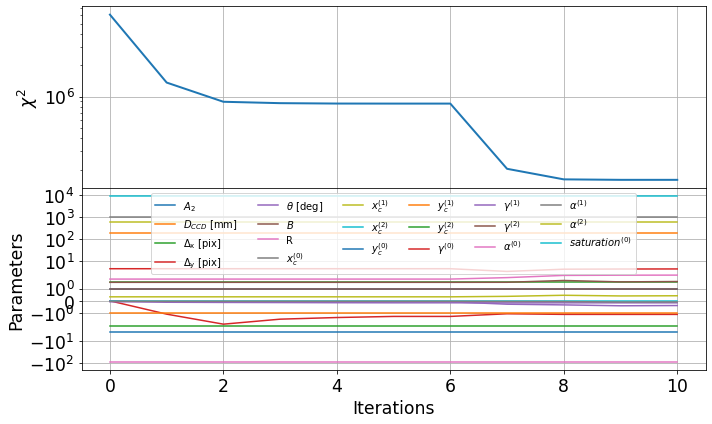

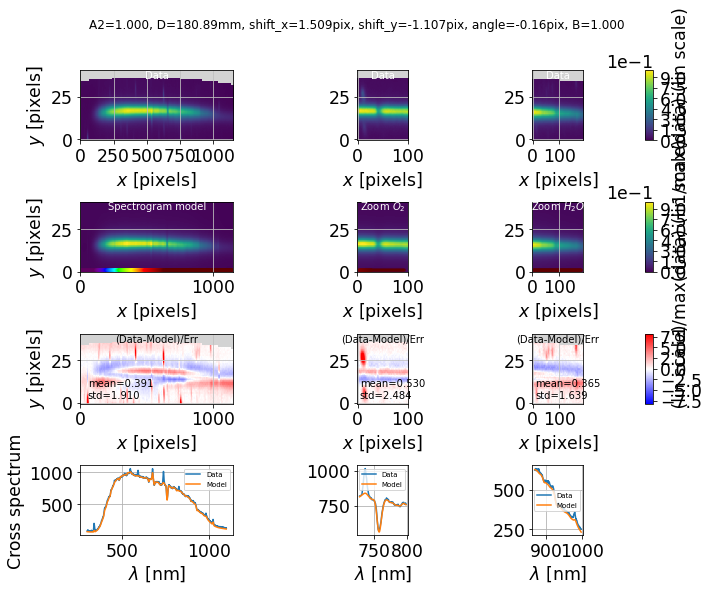

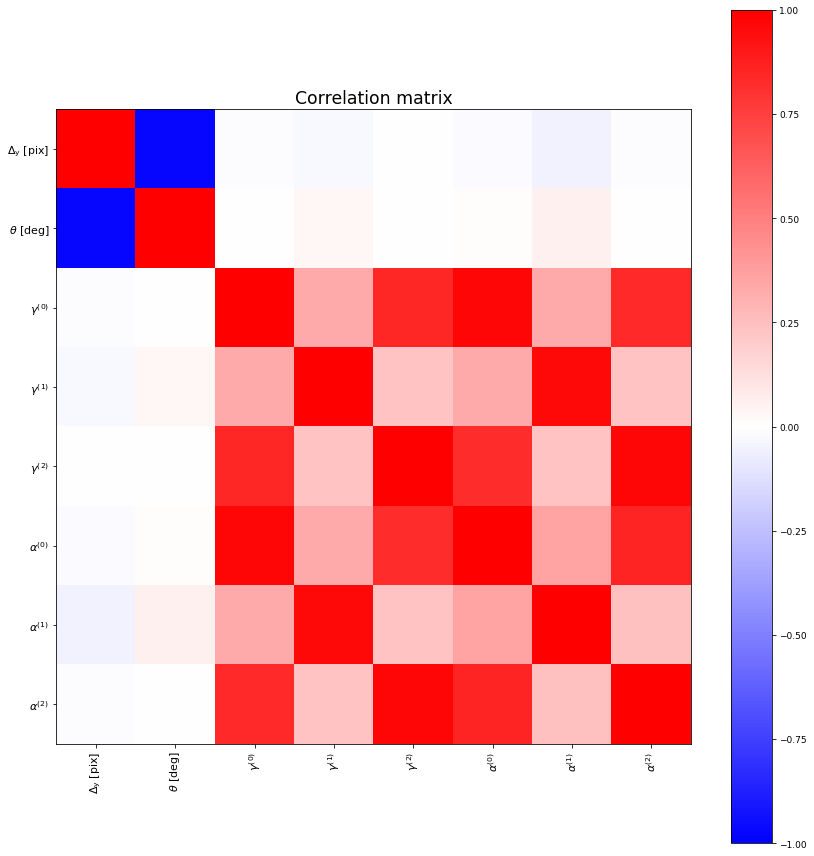

2021-10-08 15:30:52  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
/users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2021-10-08 15:31:02  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[-0.344125 ],
       [-0.3441875]]), array([4.2468048e-09, 4.2468048e-09]))
           fun: 4.246804804729956e-09
       message: 'Optimization terminated successfully.'
          nfev: 44
           nit: 22
        status: 0
       success: True
             x: array([-0.344125])
2021-10-08 15:31:02  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 10.321629762649536s


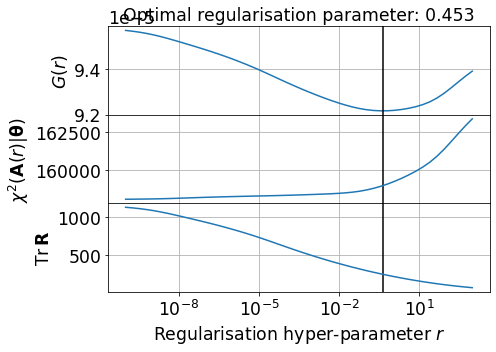

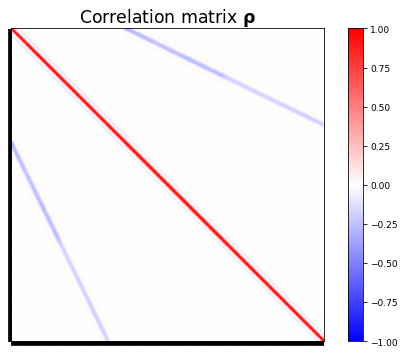

2021-10-08 15:31:29  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 0.45276724425930986
	Tr(R) = 241.37188590460025
	N_params = 1158
	N_data = 41775 (without mask and outliers)
2021-10-08 15:31:55  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5901e+05 initial chisq_red=3.8099
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 0.01013891 -0.00057936 -0.0050558  -0.01160802  0.00143041 -0.00356129
 -0.00620862  0.00194458]
	New parameters: [-1.09662013 -0.16292741  4.32763684 -0.39478688  1.57869547  2.27159724
 -0.09662813  0.41727657]
	Final cost=1.5901e+05 final chisq_red=3.8099 computed in 20.64s
2021-10-08 15:32:15  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.5901e+05 initial chisq_red=3.8099
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.00936408  0.00051318  0.00132431  0.00429967  0.00520919  0.00073168
  0.00248791  0.00276166]
	

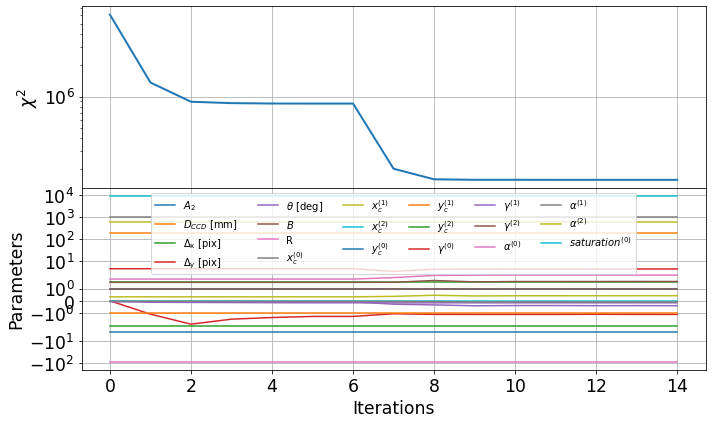

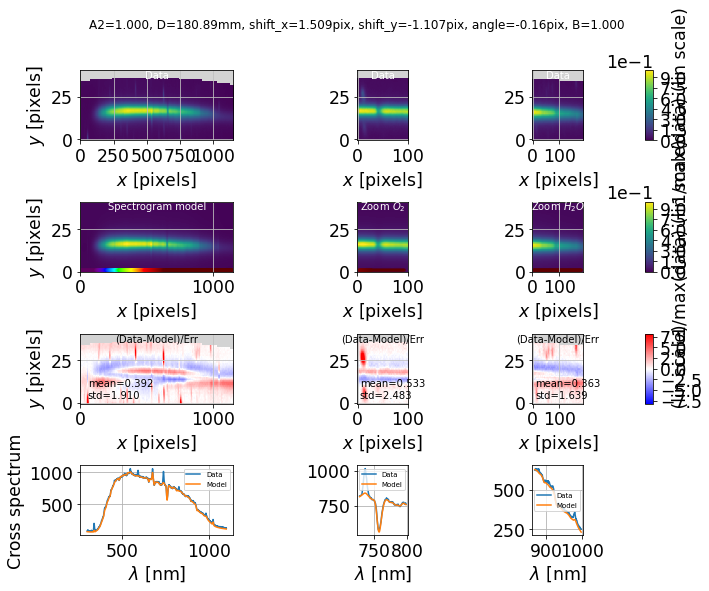

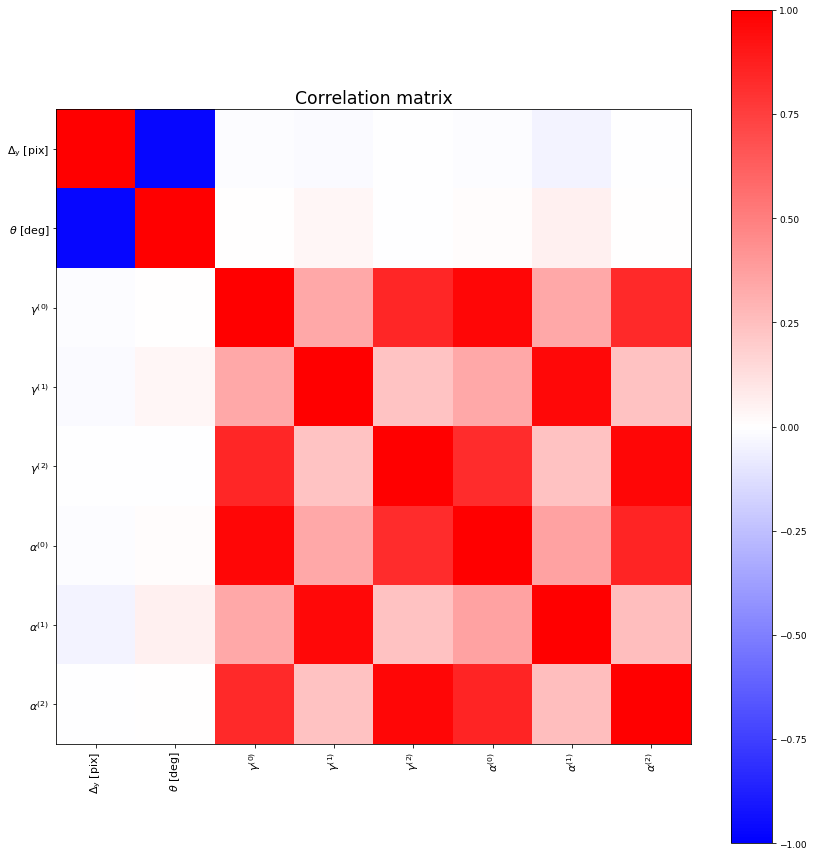

2021-10-08 15:32:39  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [55, 56, 57, 58, 1213, 1214, 1215, 1216, 2372]
2021-10-08 15:32:39  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 9 / 47478 data points (0.02%) at more than 20-sigma from best-fit model.
2021-10-08 15:33:04  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5443e+05 initial chisq_red=3.7
		 Line search: alpha_min=-0.0173 iter=4 funcalls=8
	Parameter shifts: [-1.13665547e-06  6.37809193e-08 -4.70351109e-05 -1.34707581e-04
 -1.06530725e-04 -2.37668426e-05 -6.56942314e-05 -5.37236907e-05]
	New parameters: [-1.10664763 -0.16237376  4.32802429 -0.39554835  1.58209547  2.27179736
 -0.09677888  0.41906341]
	Final cost=1.5443e+05 final chisq_red=3.7 computed in 23.40s
2021-10-08 15:33:27  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.5443e+05 initial chisq_red=3.7
		 Line search: alpha_min=0.

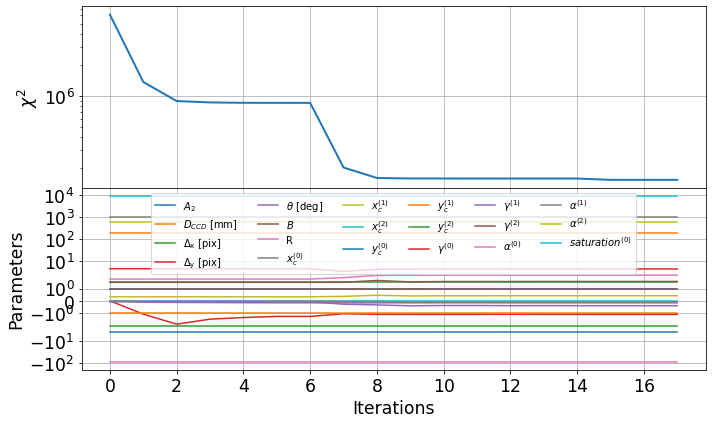

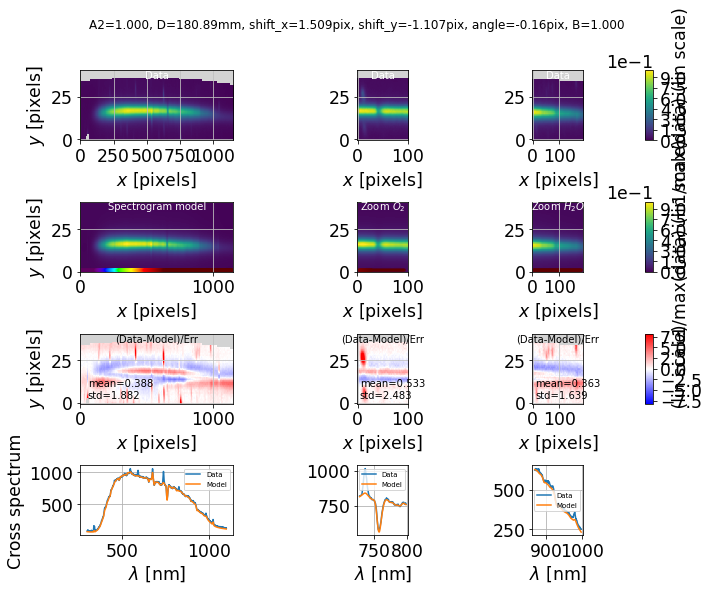

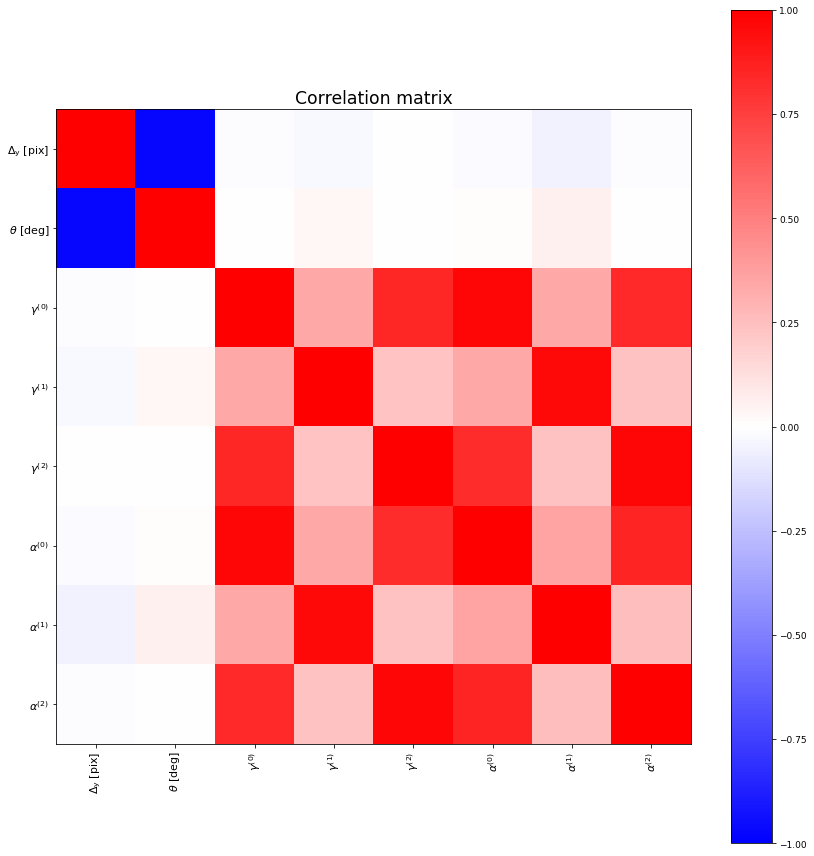

2021-10-08 15:33:32  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [55, 56, 57, 58, 1213, 1214, 1215, 1216, 2372]
2021-10-08 15:33:32  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 9 / 47478 data points (0.02%) at more than 20-sigma from best-fit model.
2021-10-08 15:33:32  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-10-08 15:33:32  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 263.02983689308167s


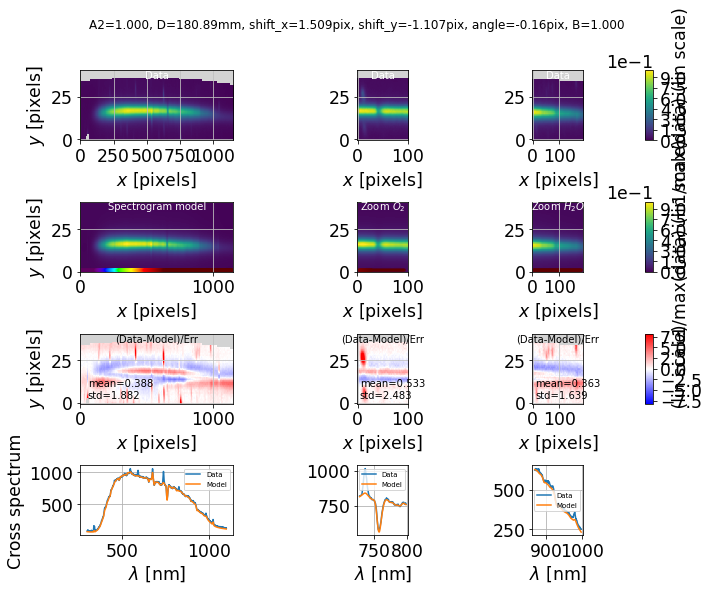

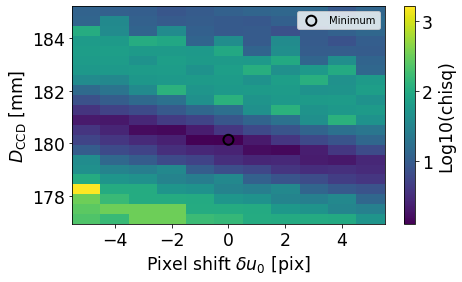

2021-10-08 15:33:51  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.288pix
	D = 180.089 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.5 sigma shift)
2021-10-08 15:34:16  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=1.5732e+05 initial chisq_red=3.7694
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [-0.01078435 -0.00041439 -0.00063788  0.02372938 -0.01667956 -0.00317865
  0.00701871 -0.01184165]
	New parameters: [-1.11734821 -0.16279395  4.32732335 -0.3740272   1.56592019  2.2686091
 -0.09073707  0.40749526]
	Final cost=1.5704e+05 final chisq_red=3.7626 computed in 21.45s
2021-10-08 15:34:38  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=1.5704e+05 initial chisq_red=3.7626
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 1.20127047e-03 -9.55464307e-05  3.50305248e-03  7.46645384e-03
 -1.27414704e-02  2.06203371e-03  3.57223547e-03 -2.51650270e-03]
	New parameters: 

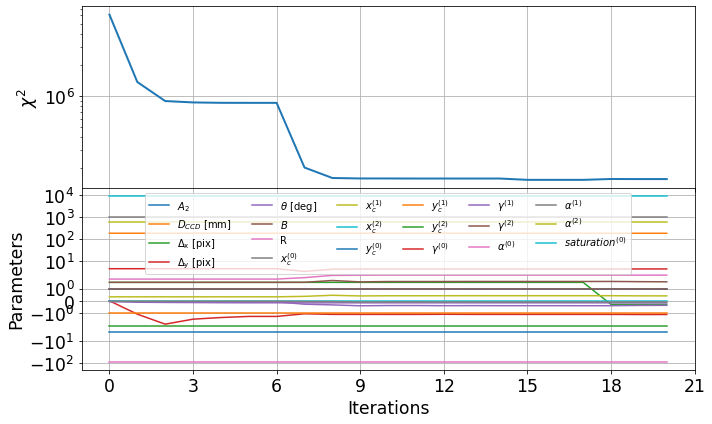

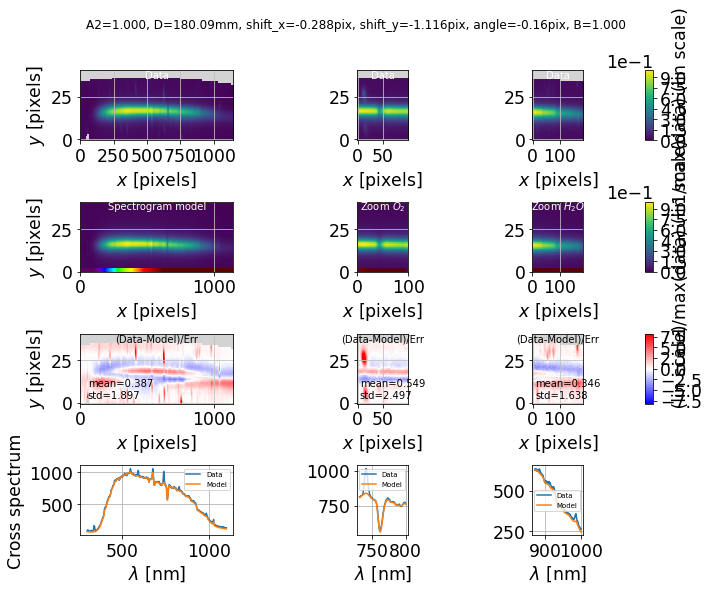

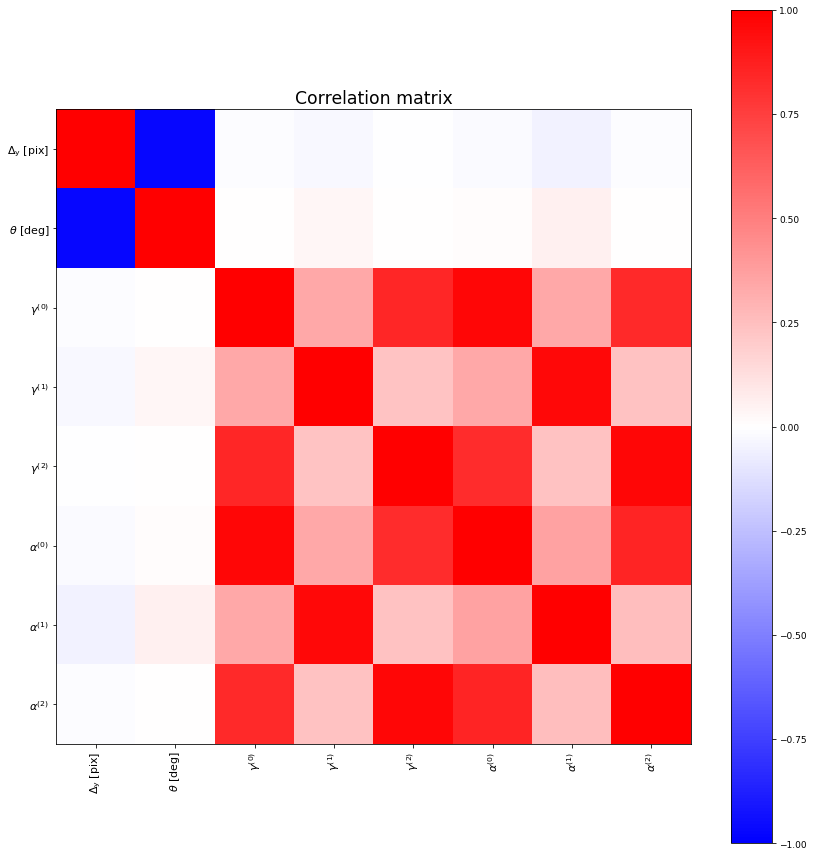

2021-10-08 15:34:43  spectractor.fit.fitter run_minimisation_sigma_clipping DEBUG  
	Outliers flat index list: [55, 56, 57, 58, 1213, 1214, 1215, 1216, 2372]
2021-10-08 15:34:43  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers: 9 / 47478 data points (0.02%) at more than 20-sigma from best-fit model.
2021-10-08 15:34:43  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	Outliers flat index list unchanged since last iteration: break the sigma clipping iterations.
2021-10-08 15:34:43  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 334.4811518192291s


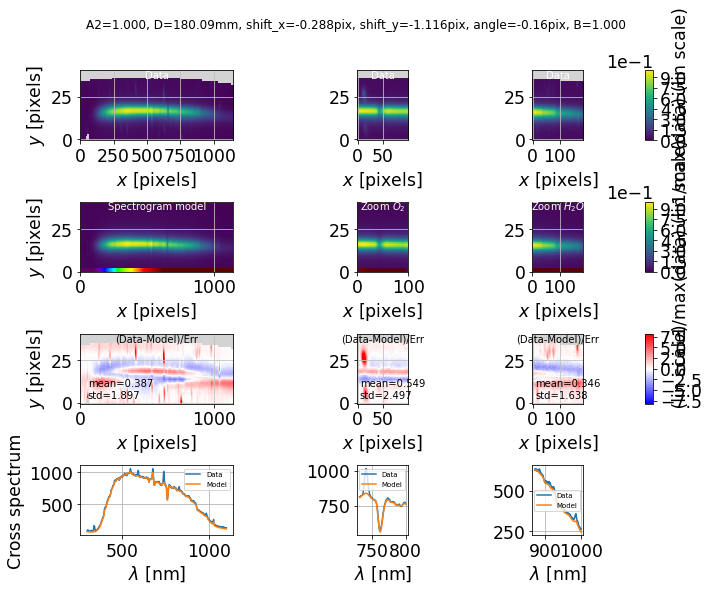

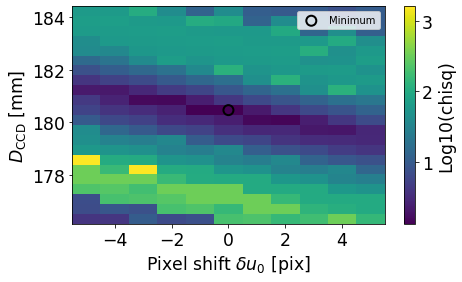

2021-10-08 15:35:03  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.169pix
	D = 180.382 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, -2.2 sigma shift)
2021-10-08 15:35:05  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-10-08 15:35:05  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-10-08 15:35:05  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrum.fits
2021-10-08 15:35:05  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo_scan/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrogram.fits


    Line    Tabulated  Detected ...   Chisq    Eqwidth_mod Eqwidth_data
                nm        nm    ...  reduced        nm          nm     
----------- --------- --------- ... ---------- ----------- ------------
   $Fe_{I}$   382.172 377.73126 ...  1.0127859   4.8325005    59.258537
  $Ca_{II}$ 393.49777 388.76718 ...  1.0127859     2.23262     9.254685
  $Ca_{II}$ 396.97995  395.2643 ...  1.0127859   1.6615592     5.918344
$H\epsilon$   397.133 403.47443 ...  1.0127859   1.0974157     8.741785
  $H\delta$  410.3374  409.6151 ...  1.0127859   1.3204883    6.0219107
   $Fe_{I}$ 430.93433 420.89795 ...  1.0127859   2.7888172    10.054616
  $H\gamma$  434.1454 432.78204 ...  1.0127859   2.1543872     6.422112
   $Fe_{I}$ 438.50186 442.61298 ...  1.0127859   0.9459568     5.157691
   $He_{I}$  447.2498 451.17572 ...  1.0127859   1.6355567    3.6789753
   $H\beta$ 486.46292 485.46304 ... 0.46011487  0.34565365   0.28391165
   $Fe_{I}$  527.2156  528.2052 ... 0.46011487  0.24226183   0.2

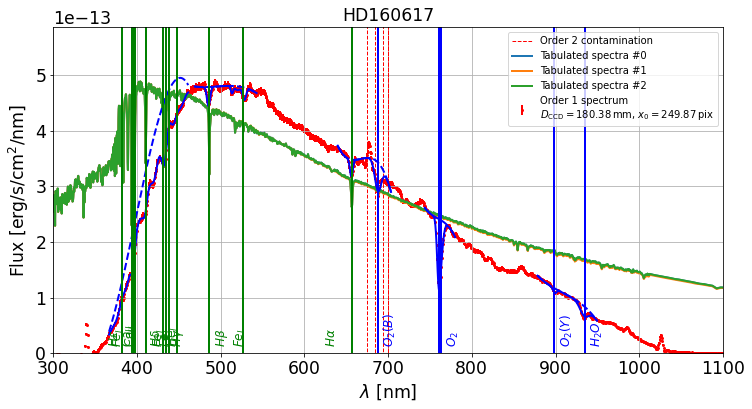

In [130]:
#spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
spectrum = Spectractor(filename_image, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Remove temporary input image file (current directory)

In [131]:
os.remove(filename_image)

# Backup output

In [132]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/basespec/holo4_003_empty_HD160617_20210707_000317_quickLookExp_lines.csv']

In [133]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/HD160617_spectrum.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/holo4_003_empty_HD160617_20210707_000317_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractor/2021-07-07/